## Imports

In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib inline to creating seperate window for matplotlib figures it will draw it in cell output instead

## Read Dataset

In [2]:
words = open("/kaggle/input/eureka-labs/names.txt","r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

## char to id

In [4]:
chars     = sorted(list(set(''.join(words))))
stoi      = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos      = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset

In [5]:
block_size = 8 # context length : how many characters do we take to predict next one
def build_dataset(words):
    X, Y       = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] #crop and apppend

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte   = build_dataset(words[n2])

In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


## Initialize weights

In [7]:
n_hidden   = 200
vocab_size = 27
n_embd     = 10

g = torch.Generator().manual_seed(2147483647) # for reproducability
C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size))
b1 = torch.randn((n_hidden), generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

bngain = torch.ones((1,n_hidden))   #Batch normalization trainable parameter
bnbias = torch.zeros((1,n_hidden))  #Batch normalization trainable parameter
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running  = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #fan_in**0.5 kamming bias
        self.bias   = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps          = eps
        self.momentum     = momentum
        self.training     = True
        
        #parameter's (trained with backprop)
        self.gamma        = torch.ones(dim) 
        self.beta         = torch.zeros(dim)
        
        #buffers (trained with a running 'momentu update')
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) #batch mean
            xvar  = x.var(dim, keepdim=True) #batch varience
        else:
            xmean = self.running_mean
            xvar  = self.running_var
            
        xhat      = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit varience
        self.out  = self.gamma * xhat + self.beta
        
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x       = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

#------------------------------ PyTorch containers ------------------------------------    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x        = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network


n_embd   = 24  # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
g        = torch.Generator().manual_seed(2147483647) # for reproducability

model    =  Sequential ([
                            Embedding(vocab_size, n_embd),
                            FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,   bias=False), BatchNorm1d(n_hidden), Tanh(),
                            FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                            FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                            Linear(n_hidden, vocab_size)
                       ])

with torch.no_grad():
    # last layer : make less confident
    model.layers[-1].weight *= 0.1
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

76579


In [10]:
from tqdm import tqdm

In [11]:
max_steps  = 20000
batch_size = 32
lossi      = []
ud         = []

for i in tqdm(range(max_steps)):
    
    #minibatch construct
    ix     = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass           
    logits = model(Xb)
    loss   = F.cross_entropy(logits, Yb) # loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 5000 == 0: #print every once in while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
#     if i > 1000:
#         break # AFTER DEBUG : would take out obviously to run full optimization

  0%|          | 2/20000 [00:00<17:22, 19.18it/s]

      0/  20000: 3.295902


 25%|██▌       | 5043/20000 [00:21<01:02, 237.44it/s]

   5000/  20000: 2.151274


 50%|█████     | 10031/20000 [00:43<00:43, 228.51it/s]

  10000/  20000: 1.782374


 75%|███████▌  | 15026/20000 [01:06<00:31, 159.85it/s]

  15000/  20000: 2.270511


100%|██████████| 20000/20000 [01:27<00:00, 227.83it/s]


### Layer Inspector 

In [12]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


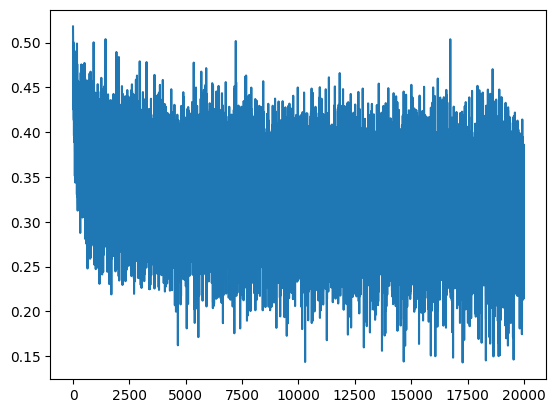

In [13]:
plt.plot(lossi)

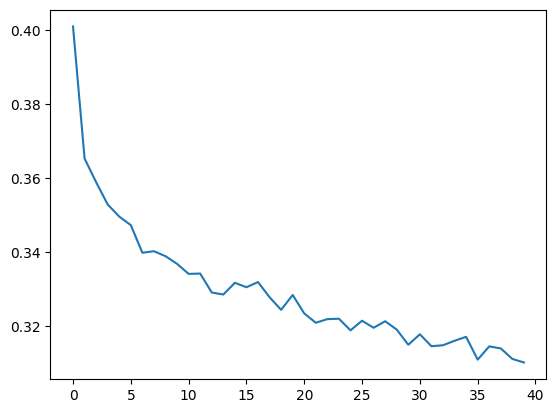

In [14]:
plt.plot(torch.tensor(lossi).view(-1,500).mean(1))

In [15]:
#put the model into eval mode
for layer in model.layers:
    layer.training = False

In [16]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x, y    = {'train' : (Xtr, Ytr), 'val' : (Xval, Yval), 'test' : (Xte, Yte)}[split]
    logits  = model(x)                                            # output layer
    loss    = F.cross_entropy(logits, y)                                     # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0511221885681152
val 2.105168104171753


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    
    while(True):
        logits  = model(torch.tensor([context])) # (1,block_size,d)
        probs   = F.softmax(logits, dim=1)
        ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            #util . comes again
            break
    print(''.join(itos[i] for i in out))

maraiyah.
zhieer.
ndylynn.
renven.
endrae.
razelynne.
ivenly.
jennedelle.
nanar.
kayzion.
karin.
shaber.
shimie.
trinton.
kynlen.
pairy.
kamied.
ryylen.
meksylah.
maykella.


## performance log
* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.918, val 2.027
* flat -> hierarchical (22K params): train 1.941, val 2.029
* fix bug in batchnorm: train 1.912, val 2.022
* scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

# **Next time :**
Why convolutions? Brief preview/hint

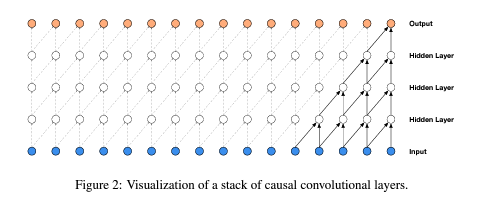
* in CNN model slids over the input array intenally using cuda to calculate the next token in the sequnce.
* Like if we have batch size of 8 then there will internal cuda for loop which will run our model 8 times to calculate 8 outputs.
* In convolutional network linear layer works as filter.


In [18]:
Xtr.shape

torch.Size([182625, 8])

In [19]:
for x, y in zip(Xtr[0:7], Ytr[0:7]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .


In [20]:
Xtr[[3]]

tensor([[ 0,  0,  0,  0,  0, 25, 21,  8]])

In [21]:
# forward single example
logits = model(Xtr[[0]]) # double brackets [[]] we suppose send 2 dim vector 0th dim of batch and 2nd of input data
logits.shape

torch.Size([1, 27])

In [22]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[0+i]])
logits.shape

torch.Size([8, 27])

# Lecture summary : 
* Implemented the containers from PyTorch like : Sequential